# Extended SONIC model - validation of custom connection scheme

## Rationale

### Objective
Create a custom implementation of the *NEURON* ***connect*** function to connect 2 sections together that:
- Allows to specify any reference voltage variable to compute axial currents
- Works on a simple multi-compartmental model with multiple nodes connected in series (no branching)
- Yields accurate results
- Does not significantly hinder numerical integration

### Axial conduction in a SENN model
Let's consider the properties of a cylindrical section of diameter $D$, length $L$ and axial resistivity $r_s$ (in $\Omega \cdot cm$):

This section has the following properties:
- Axial (i.e. cross-sectional) surface area: $A_x = \pi D^2 / 4$
- Longitudinal (i.e. membrane) surface area: $A_m = \pi D L$
- Axial resistance: $R = \frac{r_s L}{A_x} = \frac{4 r_s L}{\pi D^2}$  (in $\Omega$)

If we now consider a SENN model consisting of multiple nodes (diameter $nodeD$, length $nodeL$) connected by abstract internodal segments (diameter $interD$, length $interL$), the resistance of a given node is complemented by the additional resistance of one half internode on each side, such that:

$ R_{tot} = R_{node} + R_{inter} = \frac{4 r_s}{\pi} \big(\frac{nodeL}{nodeD^2} + \frac{interL}{interD^2}\big)$

Since internodal sections are not physically represented, we must correct the nodal axial resistivity in order to account for internodal resistance:

$r_s' = r_s (1 + \frac{R_{inter}}{R_{node}})$

such that

$\frac{4 rs2' \cdot nodeL}{\pi \cdot nodeD^2} = R_{tot}$

Hence, the axial current flowing between the centers of two adjacent sections $i$ and $j$ of resistances $R_{tot}^{i}, R_{tot}^{j}$ (in $\Omega$) and voltages $V^i, V^j$ (in $mV$), respectively, is:

$I_{ax}^{i,j} = \frac{V^j - V^i}{R_{tot}^{i} / 2 + R_{tot}^{j} / 2} = 2 \frac{V^j - V^i}{R_{tot}^{i} + R_{tot}^{j}}$ (in mA)

More generally, for a section $i$ connected in series with $i-1$ and $i+1$ compartments, the total axial current flowing in the section is: 

$I_{ax}^{i} = I_{ax}^{i-1,i} + I_{ax}^{i,i+1} = 2 \big(\frac{V^i - V^{i-1}}{R_{tot}^{i} + R_{tot}^{i-1}} + \frac{V^i - V^{i+1}}{R_{tot}^{i} + R_{tot}^{i+1}}\big)$ (in mA)

Considering that all nodes and internodes are respectively uniform, we have: 

$I_{ax}^{i} = \frac{(2 V^i - V^{i-1} - V^{i+1})}{R_{tot}} \propto \frac{1}{R_{tot}}$

Thus we have the following relationships:
- increasing $nodeD$ or $interD$ decreases axial resistance and increases axial current
- increasing $r_s$ increases axial resistance and decreases axial current
- increasing $nodeL$ or $interL$ increases axial resistance and decreases axial curren

### Problem
If we connect adjacent section using the standard *NEURON* **connect** function, the contribution of axial currents to the evolution of distributed membrane potentials is computed implicitly using $v$ as the reference voltage variable.

### Solution

Implement a custom point process computing the axial current (in nA) between a section and its neighbors based on particular reference variables, and insert this point process to the concerned section in order to add axial current to the sum of currents at that section. 
- axial resistances of previous, current and next sections are provided to the mechanism as static RANGE parameters
- membrane potentials of previous, current and next sections are provided to the mechanism as POINTER variables, pointing to the reference voltage variable of choice, in order to be dynamically updated throughout the simulation

For the SENN model presented above, axial current density would be computed as 
$i_{ax, i} = \frac{I_{ax, i}}{A_m} \propto \frac{1}{R_{tot} \cdot A_m}$

### Implementation

To implement our custom connection scheme, a `SeriesConnector` class is defined that contains the following attributes & methods:
- `mechname`: the name of the custom density mechanism that computes axial current (defaults to `Iax`)
- `vref`: the name of the reference voltage variable to compute axial currents (defaults to `v`)
- `attach`: inserts a specific axial current density mechanism into a section and sets appropriate axial conduction parameters
- `connect`: connects two adjacent sections in series, by setting appropriate PARAMETER and POINTER variables to create a bi-directional link

Using this scheme, sections can be connected from the Python caller in a way that closely mimics NEURON's built-in "connect" function. For instance, in order to connect 2 sections objects named *sec1* and *sec2*:

- with *NEURON*'s **traditional** connection scheme:

```python
sec2.connect(sec1, 1, 0)
```
- with the **custom** connection scheme:

```python
connector = SeriesConnector(vref='v')
for sec in [sec1, sec2]:
    connector.attach(sec)
self.connector.connect(sec1, sec2)
```

## Validation
Let's validate our custom implementation against the classic ***connect*** function, by comparing the generation and propagation of action potentials upon intracellular electrical stimulation at one node.

### Imports
Let's import the necessary packages and modules

In [1]:
import sys
import time
import logging
import numpy as np
import matplotlib.pyplot as plt

from PySONIC.core import PulsedProtocol
from PySONIC.utils import logger, si_format, pow10_format
from ExSONIC.core import SennFiber
from ExSONIC.test import TestConnectClassicVsCustom

logger.setLevel(logging.WARNING)
tester = TestConnectClassicVsCustom()

### Parameters
Let's set some default SENN model and stimulation parameters.

By default, we will use an adaptive time step (CVODE) method, as we will see later that this method is far better than the fixed time step method to ensure convergence (sometimes at the expense of computation speed).

In [2]:
# Fiber model
fiberD = 10e-6  # fiber diameter (m)
nnodes = 3
fiber = SennFiber(fiberD, nnodes)

# Intracellular stimulation parameters
Istim = None
pp = PulsedProtocol(1e-3, 3e-3)

# Stimulation parameters
tstim = 1e-3    # s
toffset = 3e-3  # s
pp = PulsedProtocol(tstim, toffset)

### Default comparison

Let's compare the distributed membrane potential profiles obtained with both the classic and custom connection schemes, upon intracellular current injection at the threshold excitation amplitude. 

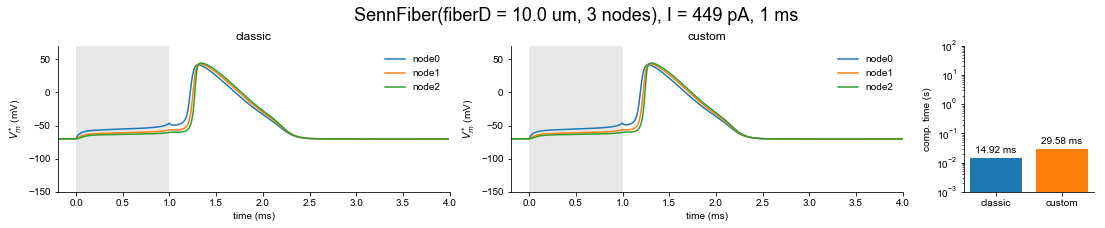

In [3]:
fig = tester.compare(fiber, None, pp)

In these default conditions, our both schemes yield identical profiles, and entail very similar computation times.

## Robustness to changes in parameters

Let's now test the robustness of our implementation to various changes in model and stimulation parameters.

### Increased axial conduction 

Let's increase the magnitude of axial currents by diminishing axial resistivity.

 03/04/2020 14:47:27: SennFiber(fiberD = 10.0 um, 3 nodes).node0: R*Am = 7.2e-02 Ohm.cm2 -> bounded to 1.0e+00 Ohm.cm2
 03/04/2020 14:47:27: SennFiber(fiberD = 10.0 um, 3 nodes).node1: R*Am = 1.4e-01 Ohm.cm2 -> bounded to 1.0e+00 Ohm.cm2
 03/04/2020 14:47:27: SennFiber(fiberD = 10.0 um, 3 nodes).node2: R*Am = 7.2e-02 Ohm.cm2 -> bounded to 1.0e+00 Ohm.cm2
 03/04/2020 14:47:27: SennFiber(fiberD = 10.0 um, 3 nodes).node0: R*Am = 7.2e-02 Ohm.cm2 -> bounded to 1.0e+00 Ohm.cm2
 03/04/2020 14:47:27: SennFiber(fiberD = 10.0 um, 3 nodes).node1: R*Am = 1.4e-01 Ohm.cm2 -> bounded to 1.0e+00 Ohm.cm2
 03/04/2020 14:47:27: SennFiber(fiberD = 10.0 um, 3 nodes).node2: R*Am = 7.2e-02 Ohm.cm2 -> bounded to 1.0e+00 Ohm.cm2
 03/04/2020 14:47:27: SennFiber(fiberD = 10.0 um, 3 nodes).node0: R*Am = 7.2e-02 Ohm.cm2 -> bounded to 1.0e+00 Ohm.cm2
 03/04/2020 14:47:27: SennFiber(fiberD = 10.0 um, 3 nodes).node1: R*Am = 1.4e-01 Ohm.cm2 -> bounded to 1.0e+00 Ohm.cm2
 03/04/2020 14:47:27: SennFiber(fiberD = 10.0 um

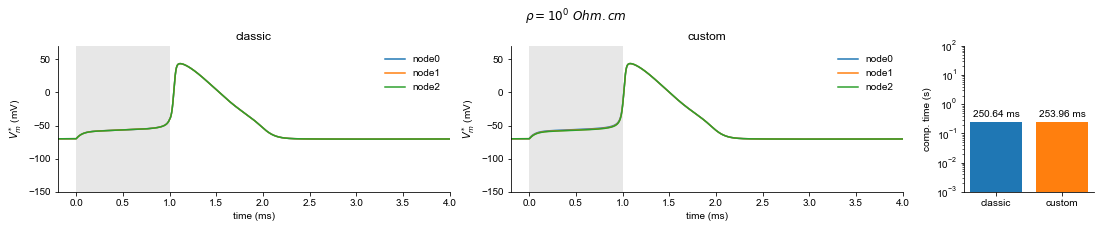

In [4]:
default_rs = fiber.rs
fiber.rs = 1e0  # Ohm.cm
fig = tester.compare(fiber, None, pp)
fig.suptitle('$\\rho = {}\ Ohm.cm$'.format(pow10_format(fiber.rs)));
fiber.rs = default_rs

In this case, the magnitude of intracellular currents is such that all nodes are completely synchronized. Nevertheless, the custom connection scheme is very accurate, and computation times are highly similar.

### Number of nodes

Let's vary the number of nodes from 3 to 9

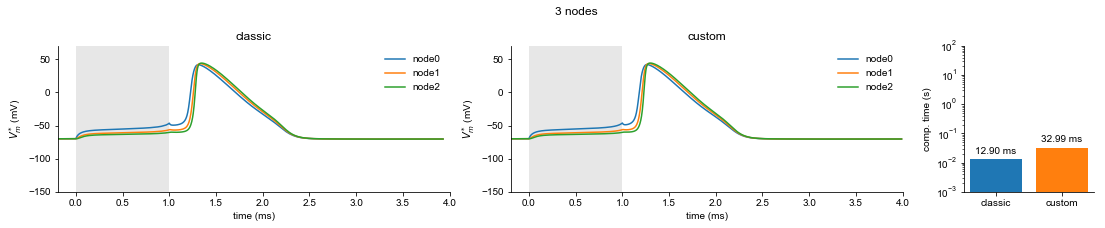

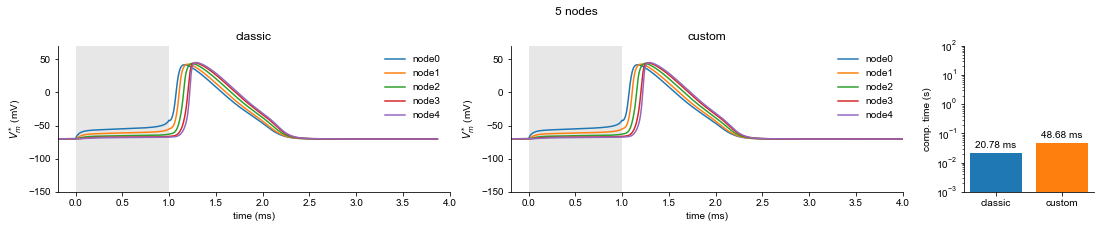

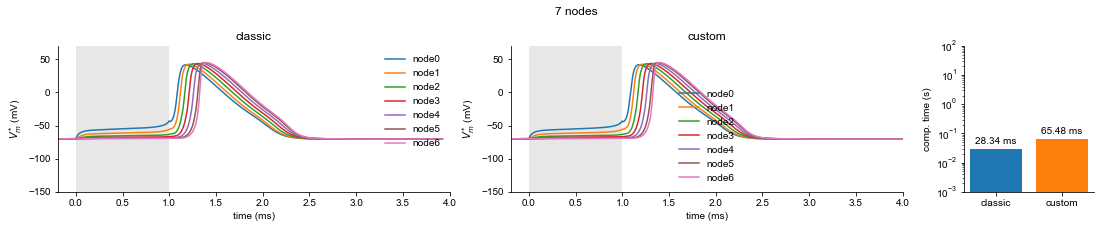

In [9]:
for nnodes_range in range(3, 9, 2):
    fig = tester.compare(SennFiber(fiberD, nnodes_range), None, pp)
    fig.suptitle(f'{nnodes_range} nodes')

Our implementation is also robust to changes in $n_{nodes}$. Moreover, in both cases, computation times increase as a function of the number of nodes.

### Stimulus amplitude

Let's vary the stimulation amplitude from 1 order of magnitude below the excitation threshold to one order of magnitude above it:

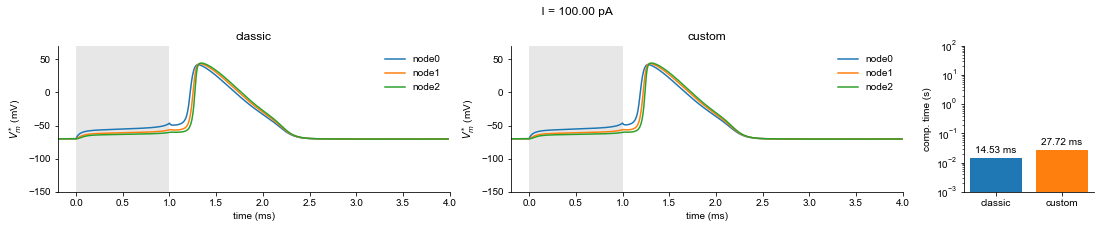

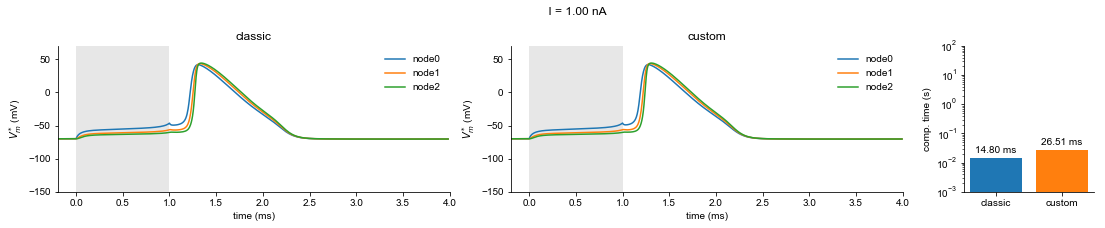

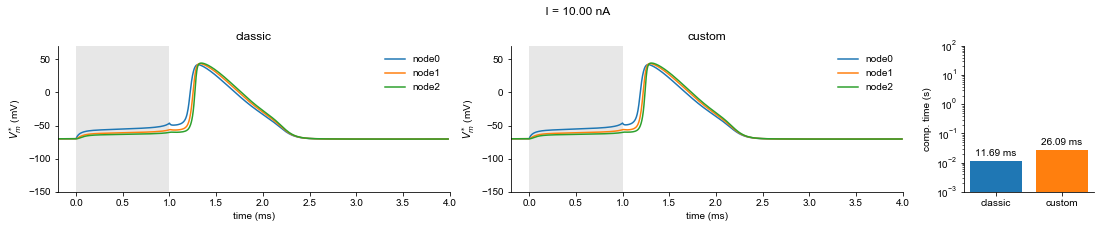

In [10]:
for Istim in np.logspace(-10, -8, 3):
    fig = tester.compare(fiber, Istim, pp)
    fig.suptitle(f' I = {si_format(Istim, 2)}A')

Again, the custom connection scheme is robust to changes in stimulus amplitude.

### Pulsing protocol

Lets' vary the duty cycle within the same overall duration, in order to change the number of pulses: 

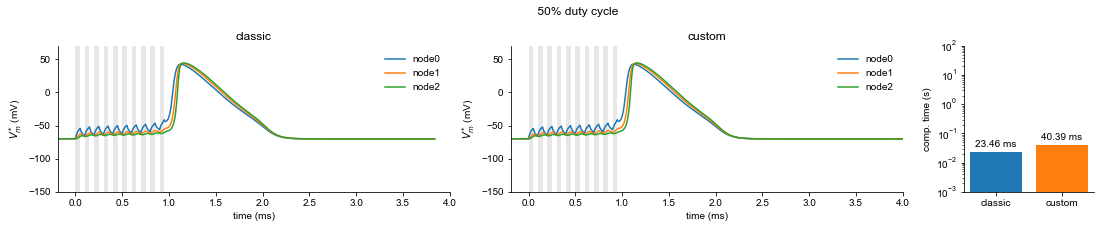

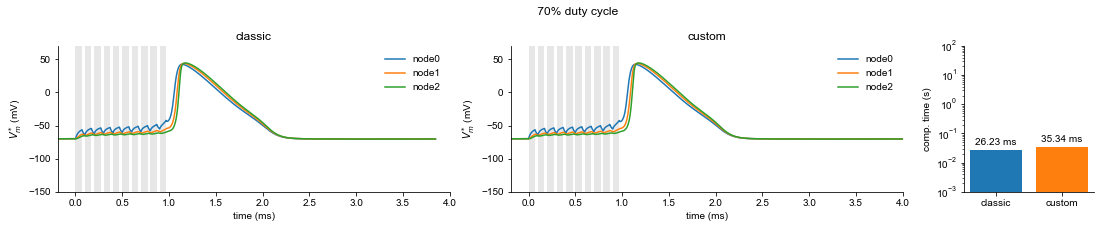

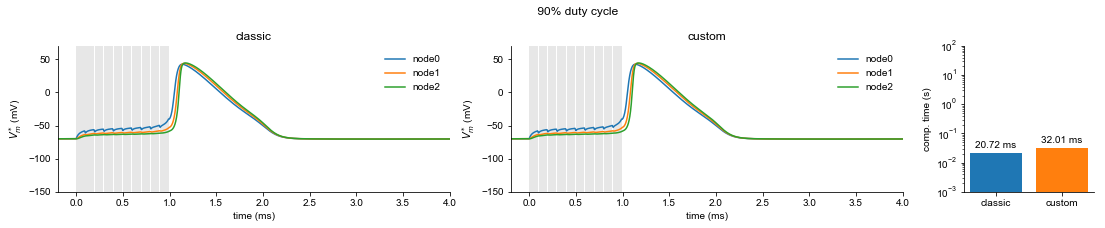

In [11]:
PRF = 1e4  # Hz
Istim = 1e-9  # nA
for DC_range in np.linspace(0.5, 0.9, 3):
    fig = tester.compare(fiber, Istim, PulsedProtocol(pp.tstim, pp.toffset, PRF, DC_range))
    fig.suptitle(f' {DC_range * 1e2:.0f}% duty cycle')

The custom connection scheme is accurate also with pulsed protocols, hence it is robust to the repeated alternation of ON and OFF periods. 

## Conclusions

- The **custom implementation** of axial currents contribution as a density mechanism is **accurate across all conditions**.
- Simulation results confirm that **cross-node synchronization is proportional to the magnitude of axial currents** with both schemes 
- The workaround solution does not increase computation time within the range of tested parameter combinations.